In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
path = r'D:\Work\Box Sync\Trends_all states\Decennial Census Pop\\'

In [3]:
def read_data(path, name):
    df = pd.read_csv(path+name, low_memory=False)
    df = df.tail(-1).reset_index(drop=True)
    df = df.iloc[:,:3]
    print(df.head())
    return df
 
def check_data(df):
    '''
    some cells have wired values i.e. GEO_ID 1600000US0103076 NAME Auburn city, Alabama  P001001 53380(r38811)
    '''
    len_df = len(df)
    for i in range(len_df):
        if not df.iloc[i,2].isdigit():
        # print("Index of the cell:", i)
            df.iloc[i,2] = df.iloc[i,2].split('(')[0]
    df.iloc[:,2] = df.iloc[:,2].astype('float')
    return df


In [4]:
# geocorr2000_14SEP1958292.csv is 2000 census population data at place level
# derived from geocorr2000 using place to place conversion
# since I couldn't find 2000 place level population from census
p_2000 = pd.read_csv(path + 'geocorr2000_14SEP1958292.csv')
p_2000 = p_2000.tail(-1)
p_2000['GEOID'] = p_2000[['state','placefp']].astype(str).agg(''.join, axis=1)
p_2000['pop2k'] = p_2000['pop2k'].astype('float')
p_2000 = p_2000[['GEOID', 'placenm', 'pop2k']]

In [5]:
p_2000.dtypes

GEOID       object
placenm     object
pop2k      float64
dtype: object

In [6]:
# US decennial census population at place level
# downloaded from census bureau data base
p_2010 = read_data(path, 'DECENNIALPL2010.P1-Data.csv')
p_2020 = read_data(path, 'DECENNIALPL2020.P1-Data.csv')

             GEO_ID                      NAME P001001
0  1600000US0100100       Abanda CDP, Alabama     192
1  1600000US0100124   Abbeville city, Alabama    2688
2  1600000US0100460  Adamsville city, Alabama    4522
3  1600000US0100484     Addison town, Alabama     758
4  1600000US0100676       Akron town, Alabama     356
             GEO_ID                      NAME P1_001N
0  1600000US0100100       Abanda CDP, Alabama     133
1  1600000US0100124   Abbeville city, Alabama    2358
2  1600000US0100460  Adamsville city, Alabama    4366
3  1600000US0100484     Addison town, Alabama     659
4  1600000US0100676       Akron town, Alabama     225


In [7]:
p_2010 = check_data(p_2010)
p_2020 = check_data(p_2020)

In [8]:
df_10_20_merged = p_2020.merge(p_2010, on ='GEO_ID', how ='outer', indicator =True)
df_10_20_merged['GEOID'] = df_10_20_merged['GEO_ID'].str[-7:]

In [9]:
df_10_20_merged['_merge'].value_counts()

_merge
both          29262
left_only      2647
right_only      252
Name: count, dtype: int64

In [10]:
# df_10_20_merged[df_10_20_merged['_merge'] == 'right_only'].sort_values('NAME_y').tail(60)

In [11]:
df_10_20_merged.columns = ['GEO_ID', 'NAME_2020', 'P_2020', 'NAME_2010', 'P_2010', '_merge_20_10', 'GEOID']

In [12]:
df_master = df_10_20_merged.merge(p_2000, on = 'GEOID', how ='outer', indicator = True)

In [13]:
# df_master.columns
df_master['_merge_20_10'].value_counts()

_merge_20_10
both          29262
left_only      2647
right_only      252
Name: count, dtype: int64

In [14]:
# df_master[df_master['_merge_20_10']!='both'].to_csv(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\NC_submission\non_matched_census_places_00_10.csv')

In [15]:
df_master.rename(columns={"pop2k" : "P_2000"}, inplace=True)
df_master['_merge'].value_counts()
df_master[df_master['_merge']!='both'].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\non_matched_census_places.csv')
df_master[(df_master['_merge']=='both') & (df_master['_merge_20_10']=='both')].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\matched_census_places.csv')

In [16]:
df_common = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\matched_census_places_corrected_checked.csv')

In [17]:
# # trying with Illinois first
# df_master_IL = df_master[df_master['GEOID'].str.startswith('17')]
# df_common = df_master_IL[df_master_IL['_merge']=='both']
# df_common.shape, df_master_IL.shape, df_common.columns

In [18]:
df_common = df_common[(df_common["P_2020"]!=0)]
df_common = df_common[~(df_common["P_2010"]==0)]
df_common = df_common[~(df_common['NAME_2020'] =='Yeehaw Junction CDP, Florida')]

In [19]:
df_common['from_2010_to_2020'] = (df_common['P_2020'] - df_common['P_2010'])
df_common['from_2000_to_2010'] = (df_common['P_2010'] - df_common['P_2000'])
df_common['from_2000_to_2020'] = (df_common['P_2020'] - df_common['P_2000'])

In [20]:
df_common[['GEOID','NAME_2020', 'P_2000', 'P_2010', 'P_2020','from_2000_to_2010', 'from_2010_to_2020',]].isna().sum()

GEOID                0
NAME_2020            0
P_2000               0
P_2010               0
P_2020               0
from_2000_to_2010    0
from_2010_to_2020    0
dtype: int64

In [21]:
df_common = df_common[['GEOID', 'NAME_2020', 'P_2000','P_2010', 'P_2020', 'from_2000_to_2010', 'from_2010_to_2020','from_2000_to_2020']]

In [22]:
df_common['%_2000_to_2010'] = (df_common['P_2010'] - df_common['P_2000'])/ df_common['P_2000']
df_common['%_2010_to_2020'] = (df_common['P_2020'] - df_common['P_2010'])/ df_common['P_2010']
df_common['changeConsecDecade'] = df_common['%_2010_to_2020'] + df_common['%_2000_to_2010']
df_common['total_changeRate'] = (df_common['P_2020'] - df_common['P_2000'])/ df_common['P_2000']
df_common['mean_changeRate'] = (1/20)*(df_common['%_2000_to_2010']  + df_common['%_2010_to_2020'])
df_common['sign_2000_2010'] = np.sign(df_common['%_2000_to_2010'])
df_common['sign_2010_2020'] = np.sign(df_common['%_2010_to_2020'])
df_common['sign_2000_2020'] = np.sign(df_common['total_changeRate'])
print(df_common.shape)

(24296, 16)


In [23]:
df_final = df_common.dropna()
df_common.shape, df_final.shape

((24296, 16), (24296, 16))

In [24]:
df = df_final.copy().reset_index(drop=True)
df['GEOID'] = df['GEOID'].astype(str).str.rjust(7,'0')
print(df.columns, df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# slicing column value to match with shapefile for joining
print(df['mean_changeRate'].max(), df['mean_changeRate'].mean(), df['mean_changeRate'].min())
print(df['total_changeRate'].max(), df['total_changeRate'].mean(),df['total_changeRate'].min())

Index(['GEOID', 'NAME_2020', 'P_2000', 'P_2010', 'P_2020', 'from_2000_to_2010',
       'from_2010_to_2020', 'from_2000_to_2020', '%_2000_to_2010',
       '%_2010_to_2020', 'changeConsecDecade', 'total_changeRate',
       'mean_changeRate', 'sign_2000_2010', 'sign_2010_2020',
       'sign_2000_2020'],
      dtype='object') (24296, 16)
21.67012879484821 0.006576687261448197 -0.0868103448275862
261.0 0.15597939963764082 -0.996551724137931


In [25]:
# from mpl_toolkits import mplot3d
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# plot_df = df[(df['total_changeRate'] < 10) & (df['mean_changeRate'] < 5)]

# ax.scatter3D(plot_df['%_2000_to_2010'], plot_df['%_2000_to_2010'],plot_df['total_changeRate'],  cmap='Greens');

In [26]:
#places_with_trend.replace(np.inf, np.nan, inplace=True)
lower = df['%_2010_to_2020'].min() - 1
upper = df['%_2010_to_2020'].max() + 1

df['change_Rate'] = pd.cut(df['%_2010_to_2020'],include_lowest=True, right =True, #right= False,
                           bins=[lower,  -0.5 , -0.1, 0, 0.1, 0.5, upper],)


In [27]:
import math
df['%annual_10_20'] = df['%_2010_to_2020']/10
lower = math.floor(df['%annual_10_20'].min())
upper = math.ceil(df['%annual_10_20'].max())
df['annual_change'] = pd.cut(df['%annual_10_20'],include_lowest=True, right= False,
                           bins=[lower,  -0.05 , -0.01, 0, 0.01, 0.05, upper],)

In [28]:
math.floor(df['%annual_10_20'].min()), df['%annual_10_20'].min()
pd.crosstab([df.sign_2000_2010, df.sign_2010_2020, df.sign_2000_2020], df.annual_change)

annual_change                                 [-1.0, -0.05)  [-0.05, -0.01)  \
sign_2000_2010 sign_2010_2020 sign_2000_2020                                  
-1.0           -1.0           -1.0                       77            3042   
                0.0           -1.0                        0               0   
                1.0           -1.0                        0               0   
                               0.0                        0               0   
                               1.0                        0               0   
 0.0           -1.0           -1.0                        2              53   
                0.0            0.0                        0               0   
                1.0            1.0                        0               0   
 1.0           -1.0           -1.0                       70            1470   
                               0.0                        0              13   
                               1.0                        6             493   
                0.0            1.0                        0               0   
                1.0            1.0                        0               0   

annual_change                                 [-0.01, 0.0)  [0.0, 0.01)  \
sign_2000_2010 sign_2010_2020 sign_2000_2020                              
-1.0           -1.0           -1.0                    4151            0   
                0.0           -1.0                       0           85   
                1.0           -1.0                       0         1863   
                               0.0                       0           28   
                               1.0                       0         1009   
 0.0           -1.0           -1.0                      40            0   
                0.0            0.0                       0            1   
                1.0            1.0                       0           22   
 1.0           -1.0           -1.0                    1041            0   
                               0.0                      32            0   
                               1.0                    2065            0   
                0.0            1.0                       0           36   
                1.0            1.0                       0         4129   

annual_change                                 [0.01, 0.05)  [0.05, 9.0)  
sign_2000_2010 sign_2010_2020 sign_2000_2020                             
-1.0           -1.0           -1.0                       0            0  
                0.0           -1.0                       0            0  
                1.0           -1.0                     349           28  
                               0.0                      10            8  
                               1.0                     709          141  
 0.0           -1.0           -1.0                       0            0  
                0.0            0.0                       0            0  
                1.0            1.0                      14            6  
 1.0           -1.0           -1.0                       0            0  
                               0.0                       0            0  
                               1.0                       0            0  
                0.0            1.0                       0            0  
                1.0            1.0                    2897          406

In [29]:
pd.crosstab([df.sign_2000_2010, df.sign_2010_2020, df.sign_2000_2020], df.annual_change).sum()

annual_change
[-1.0, -0.05)      155
[-0.05, -0.01)    5071
[-0.01, 0.0)      7329
[0.0, 0.01)       7173
[0.01, 0.05)      3979
[0.05, 9.0)        589
dtype: int64

In [30]:
7329, 7172

(7329, 7172)

In [31]:
# df['trend2'].value_counts()
# df[(df['sign_2000_2010'] >0) & (df['sign_2010_2020'] >0) & (df['sign_2000_2020'] >0) & (df['%_2010_to_2020'] <= 0.1)].shape

In [32]:
pd.crosstab([df.sign_2000_2010, df.sign_2010_2020, df.sign_2000_2020], df.change_Rate)

change_Rate                                   (-1.9849999999999999, -0.5]  \
sign_2000_2010 sign_2010_2020 sign_2000_2020                                
-1.0           -1.0           -1.0                                     82   
                0.0           -1.0                                      0   
                1.0           -1.0                                      0   
                               0.0                                      0   
                               1.0                                      0   
 0.0           -1.0           -1.0                                      2   
                0.0            0.0                                      0   
                1.0            1.0                                      0   
 1.0           -1.0           -1.0                                     71   
                               0.0                                      0   
                               1.0                                      6   
                0.0            1.0                                      0   
                1.0            1.0                                      0   

change_Rate                                   (-0.5, -0.1]  (-0.1, 0.0]  \
sign_2000_2010 sign_2010_2020 sign_2000_2020                              
-1.0           -1.0           -1.0                    3043         4145   
                0.0           -1.0                       0           85   
                1.0           -1.0                       0            0   
                               0.0                       0            0   
                               1.0                       0            0   
 0.0           -1.0           -1.0                      53           40   
                0.0            0.0                       0            1   
                1.0            1.0                       0            0   
 1.0           -1.0           -1.0                    1471         1039   
                               0.0                      13           32   
                               1.0                     497         2061   
                0.0            1.0                       0           36   
                1.0            1.0                       0            0   

change_Rate                                   (0.0, 0.1]  (0.1, 0.5]  \
sign_2000_2010 sign_2010_2020 sign_2000_2020                           
-1.0           -1.0           -1.0                     0           0   
                0.0           -1.0                     0           0   
                1.0           -1.0                  1863         352   
                               0.0                    29           9   
                               1.0                  1010         709   
 0.0           -1.0           -1.0                     0           0   
                0.0            0.0                     0           0   
                1.0            1.0                    22          14   
 1.0           -1.0           -1.0                     0           0   
                               0.0                     0           0   
                               1.0                     0           0   
                0.0            1.0                     0           0   
                1.0            1.0                  4133        2895   

change_Rate                                   (0.5, 90.237]  
sign_2000_2010 sign_2010_2020 sign_2000_2020                 
-1.0           -1.0           -1.0                        0  
                0.0           -1.0                        0  
                1.0           -1.0                       25  
                               0.0                        8  
                               1.0                      140  
 0.0           -1.0           -1.0                        0  
                0.0            0.0                        0  
                1.0            1.0                        6  
 1.0           -1

In [33]:
pd.crosstab([df.sign_2000_2010, df.sign_2010_2020, df.sign_2000_2020], df.change_Rate).sum()

change_Rate
(-1.9849999999999999, -0.5]     161
(-0.5, -0.1]                   5077
(-0.1, 0.0]                    7439
(0.0, 0.1]                     7057
(0.1, 0.5]                     3979
(0.5, 90.237]                   583
dtype: int64

In [34]:
var1 = 'sign_2000_2010'
var2 = 'sign_2010_2020'
var3 = 'sign_2000_2020'
var4 = 'changeConsecDecade'
var5 = '%_2010_to_2020'
outputCol = 'trend2'
df[outputCol] = ''
df_length = len(df)
print(df_length)

for i in range(df_length):
   
    # consecutive population loss for two decades
    if (df.loc[i,var1] < 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
        if (df.loc[i,var5] <= -0.5):
            df.loc[i,outputCol] = '1 severely depopulating'
        elif (-0.5 < df.loc[i,var5] <= -0.1):
            df.loc[i,outputCol] = '2 moderately depopulating'
        else:
            df.loc[i,outputCol] = '3 slowly depopulating'
        
    # consecutive population gain for two decades
    elif (df.loc[i,var1] > 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
        if (df.loc[i,var5] >= 0.5):
            df.loc[i,outputCol] = '7 highly increasing'
        elif (0.1 <= df.loc[i,var5] < 0.5):
            df.loc[i,outputCol] = '6 moderately increasing'
        else:
            df.loc[i,outputCol] = '5 slowly increasing'
            
    # consecutive population gain/loss for two decades  
    elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] > 0):
        if (df.loc[i,var5] <= - 0.5):
            df.loc[i,outputCol] = '1 severely depopulating'
        elif (-0.5 < df.loc[i,var5] <= - 0.1):
            df.loc[i,outputCol] = '3 slowly depopulating'
        else:
            df.loc[i,outputCol] = '4 fluctuating'
            
    # consecutive population loss-gain-loss for two decades  
    elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] < 0):
        if (df.loc[i,var5] >= 0.5):
            df.loc[i,outputCol] = '7 highly increasing'
        elif (0.1 <= df.loc[i,var5] < 0.5):
            df.loc[i,outputCol] = '5 slowly increasing'
        else:
            df.loc[i,outputCol] = '4 fluctuating'

    elif (df.loc[i,var1] < 0) & (df.loc[i,var2] == 0) & (df.loc[i,var3] < 0):
        df.loc[i,outputCol] = '4 fluctuating'
    elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] == 0):
        df.loc[i,outputCol] = '4 fluctuating'
    elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] == 0):
        df.loc[i,outputCol] = '4 fluctuating'
    elif (df.loc[i,var1] > 0) & (df.loc[i,var2] == 0) & (df.loc[i,var3] > 0):
        df.loc[i,outputCol] = '4 fluctuating'
   
    # gain-loss-loss
    elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
        if (df.loc[i,var5] <= - 0.5):
            df.loc[i,outputCol] = '1 severely depopulating'
        elif (-0.5 < df.loc[i,var5] <= - 0.1):
            df.loc[i,outputCol] = '2 moderately depopulating'
        elif (df.loc[i,var5] > - 0.1):
            df.loc[i,outputCol] = '3 slowly depopulating'
            
    # loss-gain-gain  
    elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
        if (df.loc[i,var5] >= 0.5):
            df.loc[i,outputCol] = '7 highly increasing'
        elif (0.1 <= df.loc[i,var5] < 0.5):
            df.loc[i,outputCol] = '6 moderately increasing'
        elif (df.loc[i,var5] < 0.1):
            df.loc[i,outputCol] = '5 slowly increasing'
        
    elif (df.loc[i,var1] == 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
        if (df.loc[i,var5] <= - 0.1):
            df.loc[i,outputCol] = '2 moderately depopulating'
        elif (df.loc[i,var5] > - 0.1):
            df.loc[i,outputCol] = '3 slowly depopulating'
        
    elif (df.loc[i,var1] == 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
        if (df.loc[i,var5] >= 0.1):
            df.loc[i,outputCol] = '6 moderately increasing'
        elif (df.loc[i,var5] < 0.1):
            df.loc[i,outputCol] = '5 slowly increasing'
            
    else:
        df.loc[i,outputCol] = np.nan

24296


In [35]:
(159+4569+5721)/df['trend2'].sort_values().value_counts().sum(), (5508+3626+575)/df['trend2'].sort_values().value_counts().sum(), 4136/df['trend2'].sort_values().value_counts().sum()

(0.4300884955752212, 0.3996295534060506, 0.1702407902860671)

In [36]:
df['trend2'].sort_values().value_counts()

trend2
3 slowly depopulating        5721
5 slowly increasing          5509
2 moderately depopulating    4569
4 fluctuating                4136
6 moderately increasing      3626
7 highly increasing           575
1 severely depopulating       159
Name: count, dtype: int64

In [37]:
import geopandas as gpd

US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_places.crs

<Geographic 2D CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_Am ...>
Name: NAD83
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
# !pip install pyproj


In [39]:
US_places = US_places.to_crs('EPSG:9311')

In [40]:
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_state_5m.zip')
US_states = US_states.to_crs('EPSG:9311')

In [41]:
df_plot = US_places.merge(df, on = 'GEOID', how = 'outer',)

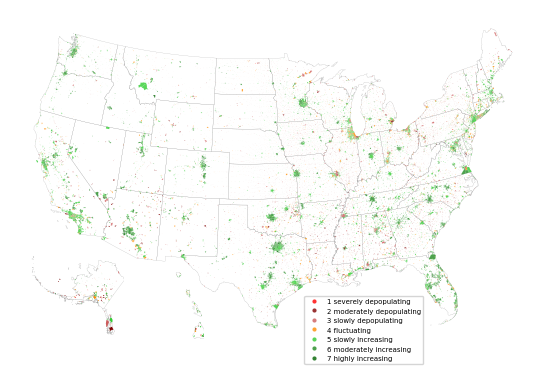

In [50]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df_plot.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen']
import matplotlib
cmap_color = matplotlib.colors.ListedColormap(colors)
plotted_col = 'trend2'

mm = 1/(10* 2.54)  # milimeters in inches
# plt.subplots(figsize=(165*mm, 200*mm))

# create an axis with 2 insets − this defines the inset sizes
fig, continental_ax = plt.subplots(figsize=(140*mm, 120*mm))
alaska_ax = continental_ax.inset_axes([.01, .02, .24, .24])
hawaii_ax = continental_ax.inset_axes([.22, .01, .25, .20])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2246944.04, 918095.9)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)

# Bounds for populated areas in Hawaii
hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)
hawaii_ax.set_ylim(-1050846.93031638, -455238.37803499)

US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.1)
gdf.plot(column=plotted_col, categorical =True,
                                  ax=continental_ax,
                                  cmap=cmap_color,
                                  alpha = 0.8,
                                  legend = True,
                                  legend_kwds={'fontsize':5,
                                              'markerscale': 0.3}
        ) #, vmin=vmin, vmax=vmax)

leg = continental_ax.get_legend()
leg.set_bbox_to_anchor((0.2, -0.05, 0.6, 0.2))

# from shapely.geometry.point import Point
# points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-75.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
# points = points.to_crs(9311)  # Projected WGS 84 - meters
# from matplotlib_scalebar.scalebar import ScaleBar
# distance_meters = points[0].distance(points[1])
# scale_ax = continental_ax.inset_axes([.01, -.02, .2, .4])
# scale_ax.add_artist(ScaleBar(distance_meters, dimension="si-length", units="km", location='lower left', font_properties ={'size':'x-large'}))
# arrow_ax = continental_ax.inset_axes([.01, 0.0, .2, .4])
# plot_north_arrow(arrow_ax, xT=0, yT=0, scale=.01)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=alaska_ax)
gdf.plot(column=plotted_col, cmap=cmap_color, ax=alaska_ax) #, vmin=vmin, vmax=vmax)
US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
gdf.plot(column=plotted_col, cmap=cmap_color, ax=hawaii_ax) #, vmin=vmin, vmax=vmax)

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)
    
fig.savefig(r'D:\Work\Box Sync\NC Figures\cities_relabeled.png', dpi = 300, bbox_inches='tight')
fig.savefig(r'D:\Work\Box Sync\NC Figures\cities_relabeled.pdf', dpi = 300, bbox_inches='tight')

In [ ]:
# fig, alaska_ax = plt.subplots(figsize=(20, 30))
# alaska_ax.set_xlim(-4337634.21863075, -1564427.75408087)
# alaska_ax.set_ylim(1528047.16872635, 3883917.63673733)
# US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=alaska_ax)
# # gdf.plot(column=plotted_col, cmap=cmap_color, ax=alaska_ax) #, vmin=vmin, vmax=vmax)

# gdf[(gdf['GEOID'].str.startswith('02')) & (gdf['trend2'] == '2 moderately depopulating')][['GEOID','NAME_2020', 'P_2000', 'P_2010', 'P_2020']].tail(50)

In [ ]:
df_plot['density_km2'] = df_plot['P_2020']*1000*1000/df_plot['ALAND']
df_plot[df_plot['density_km2'] != 0].groupby('trend2')['density_km2'].describe().round(2)

In [ ]:
forecasted_trend = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\forecasted_trend.csv', index_col =0, dtype={'GEOID': 'string'})

In [ ]:
forecasted_trend.isna().sum(), forecasted_trend.shape

In [ ]:
df_plot.isna().sum()

In [ ]:
df_plot

In [ ]:
df_current_merged_future = df_plot.merge(forecasted_trend, on ='GEOID', how= 'outer', indicator= True)

In [ ]:
(df_current_merged_future.groupby(['trend2', 'future trend from SSP 4']).size()/df_current_merged_future.groupby(['trend2']).size()).round(3)

In [ ]:
# get state names
state_names= US_states[['STATEFP', 'NAME']]
# Percent cities in each trend group
# pd.set_option('display.max_rows', None)
df = df_current_merged_future.copy()
column_name = 'trend2' #'future trend from SSP 1'

percent_cities = (df.groupby(['STATEFP', column_name]).count()[['GEOID']] /
                  df.groupby(['STATEFP']).count()[['GEOID']]).reset_index()

table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'
                    columns=[column_name], aggfunc=np.sum).reset_index()

table = table.merge(state_names, on = 'STATEFP')

table['sum'] = table[['1 severely depopulating', '2 moderately depopulating','3 slowly depopulating']].sum(axis =1)
table = table.sort_values('sum', ascending = False) 
table.drop(columns = ['sum',], inplace = True)
colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen',]

# table = table.sort_values('decreasing', ascending = False) 
# colors = ['maroon','yellowgreen','slategray']


table.drop(columns = ['STATEFP',], inplace = True)

cmap=matplotlib.colors.ListedColormap(colors)

# plot a Stacked Bar Chart using matplotlib
ax = table.plot(
    x = 'NAME',
    kind = 'barh',
    stacked = True,
    cmap = cmap,
    title = '% Cities with current population trend',
    mark_right = True,
    figsize=(7, 12))
# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(bbox_to_anchor=(1.09, -0.04), loc='best', prop={'size': 10},  ncol=3, handleheight=2.4, labelspacing=0.05)
plt.tight_layout()
plt.show()
fig = ax.get_figure()

In [ ]:
df_current_merged_future.columns

In [ ]:
statecode = '31'
df_state = df_current_merged_future[df_current_merged_future['STATEFP'] == statecode]
print(df_state.shape)
# Cartographic boundary for plotting
US_counties_cb = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_county_5m.zip') # tl_2020_us_county
US_counties_cb = US_counties_cb.to_crs('EPSG:9311')

In [ ]:
gdf.groupby('trend2').size()

In [ ]:
# set state code as index, exclude states that we will never display
gdf = df_state.to_crs('epsg:9311') 
counties_IL = US_counties_cb[US_counties_cb['STATEFP'] == statecode].to_crs('epsg:9311') 

#.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen',]

column_name = ['trend2', "label"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 20))

counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='grey', linewidth=2)
gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 34,})
    
ax.set_title("Current population trend", fontdict={'fontsize': 45, 'fontweight': 'medium'})

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.tight_layout()
plt.axis('off') 
fig.savefig(r'D:\Work\Box Sync\Depopulation in Nebraska\Current_trend_31.png', dpi = 300, bbox_inches='tight')

In [ ]:
# set state code as index, exclude states that we will never display
gdf = df_state.to_crs('epsg:9311') 
counties_IL = US_counties_cb[US_counties_cb['STATEFP'] == statecode].to_crs('epsg:9311') 

#.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen',]

column_name = ['trend2', "label"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(35, 20))

for ax, col in zip(axes.flatten(), column_name):
    counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
    gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 20,})
    
    ax.set_title(col)


    # remove ticks
    for ax in axes.flatten():
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
    

In [ ]:
print(gdf.shape, counties_IL.shape)
gpd.sjoin(gdf, counties_IL).groupby(['GEOID_right']).size().sum()

In [ ]:
# var1 = 'sign_2000_2010'
# var2 = 'sign_2010_2020'
# var3 = 'sign_2000_2020'

# df['trend'] = ''
# df_length = len(df)
# print(df_length)

# for i in range(df_length):
   
#     '''consecutive population loss for two decades
#     '''
#     if (df.loc[i,var1] < 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
#         df.loc[i,'trend'] = 'decreasing'
#     # consecutive population gain for two decades
#     elif (df.loc[i,var1] > 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
#         df.loc[i,'trend'] = 'increasing'
#     # consecutive population gain/loss for two decades  
#     elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] > 0):
#         df.loc[i,'trend'] = 'fluctuating'
#     elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] < 0):
#         df.loc[i,'trend'] = 'fluctuating'

#     elif (df.loc[i,var1] < 0) & (df.loc[i,var2] == 0) & (df.loc[i,var3] < 0):
#         df.loc[i,'trend'] = 'fluctuating'
#     elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] == 0):
#         df.loc[i,'trend'] = 'fluctuating'
#     elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] == 0):
#         df.loc[i,'trend'] = 'fluctuating'
#     elif (df.loc[i,var1] > 0) & (df.loc[i,var2] == 0) & (df.loc[i,var3] > 0):
#         df.loc[i,'trend'] = 'fluctuating'
   
    
#     # gain-loss-loss
#     elif (df.loc[i,var1] > 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
#         df.loc[i,'trend'] = 'decreasing'
#     # loss-gain-gain  
#     elif (df.loc[i,var1] < 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
#         df.loc[i,'trend'] = 'increasing'
        
#     elif (df.loc[i,var1] == 0) & (df.loc[i,var2] < 0) & (df.loc[i,var3] < 0):
#         df.loc[i,'trend'] = 'decreasing'
        
#     elif (df.loc[i,var1] == 0) & (df.loc[i,var2] > 0) & (df.loc[i,var3] > 0):
#         df.loc[i,'trend'] = 'increasing'
#     else:
#         df.loc[i,'trend'] = np.nan

# df[df['trend'].isnull()]#.sum()

In [ ]:
# plot_df = df#[(df['%_2000_to_2010'] < 20) & (df['%_2010_to_2020'] < 20)]
# # plot_df=df
# plot_df = plot_df.replace('', np.nan, regex=True)
# fig1 = plt.figure(figsize=[20,10]) 
# axes1 = fig1.add_axes([-0.5,-0.5,0.5,0.5])
# plt.rcParams['font.family'] = "Times New Roman"
# axes1.set_xlabel("%_2000_to_2010", fontsize=20, labelpad = 80)
# axes1.set_ylabel("%_2010_to_2020", fontsize=20, labelpad= 80)
# axes1.tick_params(axis='both', which='major', labelsize=25)
# axes1.tick_params(axis='both', which='minor', labelsize=25)
# axes1.spines.left.set_position('zero')
# axes1.spines.right.set_color('none')
# axes1.spines.bottom.set_position('zero')
# axes1.spines.top.set_color('none')
# #axes1.spines[['top', 'right']].set_visible(False)
# #axes1.spines[['left','bottom']].set_position('center')

# colors = {'decreasing':'maroon', 'increasing':'yellowgreen', 'no trend':'slategray', 'no data': 'grey'}
# axes1.scatter(plot_df['changeConsecDecade'], plot_df['%_2010_to_2020'], 
#               c = plot_df['sign_2000_2020'], 
#               alpha = .4, edgecolors=None,
#               s = 8,
#              )
# # fig1.savefig(r'D:\Work\Box Sync\Trends_all states\Population classified.png', dpi = 300)
# # fig1.savefig(r'D:\Work\Box Sync\Trends_all states\Population classified.pdf', dpi = 300)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.show()

In [ ]:
# plot_df = df[(df['total_changeRate'] < 15) & (df['mean_changeRate'] < 5)]
# # plot_df=df
# plot_df = plot_df.replace('', np.nan, regex=True)
# fig1 = plt.figure(figsize=[20,8]) 
# axes1 = fig1.add_axes([-0.5,-0.5,0.5,0.5])
# plt.rcParams['font.family'] = "Times New Roman"
# axes1.set_xlabel("Mean change rate in population ($\Delta P_m$)", fontsize=20, labelpad = 100)
# axes1.set_ylabel("Total change rate in population ($\Delta P_t$)", fontsize=20, labelpad= 200)
# axes1.tick_params(axis='both', which='major', labelsize=25)
# axes1.tick_params(axis='both', which='minor', labelsize=25)
# axes1.spines.left.set_position('zero')
# axes1.spines.right.set_color('none')
# axes1.spines.bottom.set_position('zero')
# axes1.spines.top.set_color('none')
# #axes1.spines[['top', 'right']].set_visible(False)
# #axes1.spines[['left','bottom']].set_position('center')

# colors = {'decreasing':'maroon', 'increasing':'yellowgreen', 'no trend':'slategray', 'no data': 'grey'}
# axes1.scatter(plot_df['mean_changeRate'], plot_df['changeConsecDecade'], 
#               # c = plot_df['trend'].map(colors), 
#               alpha = .4, edgecolors=None,
#               # s = plot_df['density_km2_20']/15,
#              )
# # fig1.savefig(r'D:\Work\Box Sync\Trends_all states\Population classified.png', dpi = 300)
# # fig1.savefig(r'D:\Work\Box Sync\Trends_all states\Population classified.pdf', dpi = 300)

# plt.show()

In [ ]:
# df_trend = df.copy()
# #places_with_trend.replace(np.inf, np.nan, inplace=True)
# mean_lower = df_trend['mean_changeRate'].min() - 1
# mean_upper = df_trend['mean_changeRate'].max() + 1
# total_lower = df_trend['total_changeRate'].min() - 1
# total_upper = df_trend['total_changeRate'].max() + 1

# df_trend['mean_Rate'] = pd.cut(df_trend['mean_changeRate'], include_lowest=True,
#                                         bins=[mean_lower, -1.25, -0.25, -0.125, 0, 0.125, 0.25, 1.25, mean_upper],)
# df_trend['total_Rate'] = pd.cut(df_trend['total_changeRate'], bins=[total_lower,  -1 , -0.5, -0.1, 0, 0.1, 0.5, 1, total_upper],)

In [ ]:
# df_X.isna().sum()

In [ ]:
# df_X = df_trend[['GEOID','NAME_2020','P_2000', 'P_2010','P_2020',
#            '%_2000_to_2010', '%_2010_to_2020', 'total_changeRate',
#            'mean_changeRate', 'mean_Rate', 'total_Rate', 'sign_2000_2010', 'sign_2010_2020', 'sign_2000_2020']].dropna().reset_index()
# df_X.shape, df_trend.shape

# # replacing zero values before logarithmic conversion
# # df_X['density_km2_20'].replace(0,0.0001,inplace=True)
# # df_X['logarithm_density_km2_20'] = np.log2(df_X['density_km2_20'])

# df_X['total_changeRate'].where(df_X['total_changeRate']<= 9, 10, inplace=True)
# df_X['mean_changeRate'].where(df_X['mean_changeRate']<= 9, 10, inplace=True)

# features = ['sign_2000_2010', 'sign_2010_2020', 'sign_2000_2020','%_2000_to_2010', '%_2010_to_2020', 'total_changeRate',
#            'mean_changeRate'] #['total_changeRate', 'mean_changeRate'] #  
# X = df_X[features].copy() 
# X
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns = features)
# # X['logarithm_density_km2_20'] = X['logarithm_density_km2_20']/100

In [ ]:
# pd.concat([df_X, X], axis =1).sort_values('density_km2_20').head(20)

In [ ]:
# from mpl_toolkits import mplot3d
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,8))
# ax = plt.axes(projection='3d')
# x = df_X['total_changeRate']
# y = df_X['mean_changeRate']
# z = df_X['logarithm_density_km2_20']
# ax = plt.axes(projection='3d')
# ax.scatter(x, y, z, c=z, linewidth=0.5);

In [ ]:
# from sklearn.manifold import TSNE
# import seaborn as sns
# tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
# tsne_results = tsne.fit_transform(X[features])

# X['tsne-2d-one'] = tsne_results[:,0]
# X['tsne-2d-two'] = tsne_results[:,1]

# plt.figure(figsize=(4,4))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     # hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=X,
#     legend="full",
#     alpha=0.3
# )

In [ ]:
# projection = TSNE().fit_transform(X[features])
# # plt.scatter(*projection.T)

In [ ]:
# import hdbscan # conda install -c conda-forge hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, alpha=1.3).fit(X[features])
# color_palette = sns.color_palette('Paired', 12)
# cluster_colors = [color_palette[x] if x >= 0
#                   else (0.5, 0.5, 0.5)
#                   for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)]
# plt.scatter(*projection.T, s=5, linewidth=0, c=cluster_member_colors, alpha=0.25)
# # clusterer.condensed_tree_.plot()
# X['cluster'] = clusterer.labels_

# df_trend.shape
# df_clustered = pd.concat([df_X, X], axis =1)
# # df_clustered.columns
# # pd.crosstab([df_clustered.cluster, df_clustered.total_Rate], df_clustered.mean_Rate)
# pd.crosstab([df_clustered.cluster, df_clustered.total_Rate], df_clustered.mean_Rate)